In [5]:
# ============================================
# 3_Mixed_introgression.ipynb
# ============================================

# === Setup ===
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set working paths
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
simulations_path = os.path.join(project_root, 'simulations')
if simulations_path not in sys.path:
    sys.path.insert(0, simulations_path)

from common_utils import (
    simulate_introgression_scenario,
    calculate_d_statistic,
    calculate_fst,
    save_dataframe,
    plot_kde_distribution,
    sliding_window_d,
    sliding_window_fst
)

# === Output folders (local directory to avoid permissions issues) ===
os.makedirs("results/mixed_updated", exist_ok=True)
os.makedirs("figures/mixed_updated", exist_ok=True)

# === Parameters ===
n_replicates = 10
Ne = 100000

divergence_scenarios = {
    "shallow": (100000, 200000),
    "intermediate": (400000, 800000)
}

migration_rates = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 0.1,
    "super_high": 0.3
}

migration_times = {
    "recent": 10000,
    "intermediate": 50000,
    "ancient": 200000
}

# === Run Simulations ===
results = []

for div_label, (div_time_abc, div_time_ab) in divergence_scenarios.items():
    for mig_time_label, mig_time in migration_times.items():
        for mig_label, mig_rate in migration_rates.items():
            for rep in tqdm(range(n_replicates), desc=f"{div_label}-{mig_time_label}-{mig_label}"):
                ts = simulate_introgression_scenario(
                    Ne=Ne,
                    div_time_ab=div_time_ab,
                    div_time_abc=div_time_abc,
                    mig_rate=mig_rate,
                    mig_time=mig_time,
                    continuous=False,
                    migration_direction="C_to_B"
                )

                d_stat, abba, baba = calculate_d_statistic(ts)
                fst_ab, fst_bc = calculate_fst(ts)

                results.append({
                    "rep": rep,
                    "divergence": div_label,
                    "mig_time": mig_time_label,
                    "mig_rate": mig_label,
                    "D": d_stat,
                    "ABBA": abba,
                    "BABA": baba,
                    "FST_AB": fst_ab,
                    "FST_BC": fst_bc
                })

# === Save Final Combined DataFrame ===
df = pd.DataFrame(results)
save_dataframe(df, "results/mixed_updated/summary.csv")

shallow-intermediate-none:  10%|█         | 1/10 [00:01<00:10,  1.18s/it]


KeyboardInterrupt: 

# Final Plotting Code

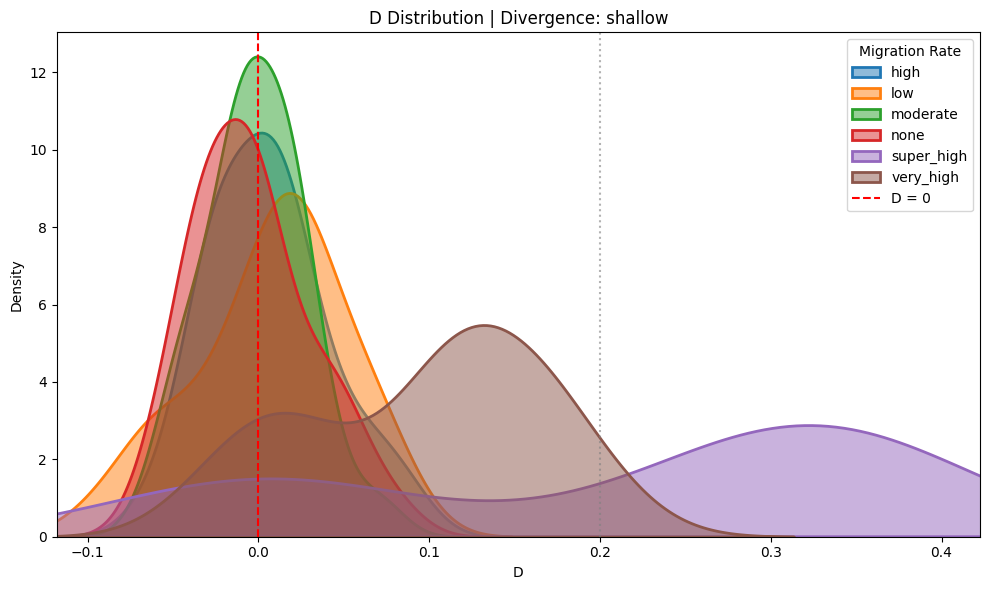

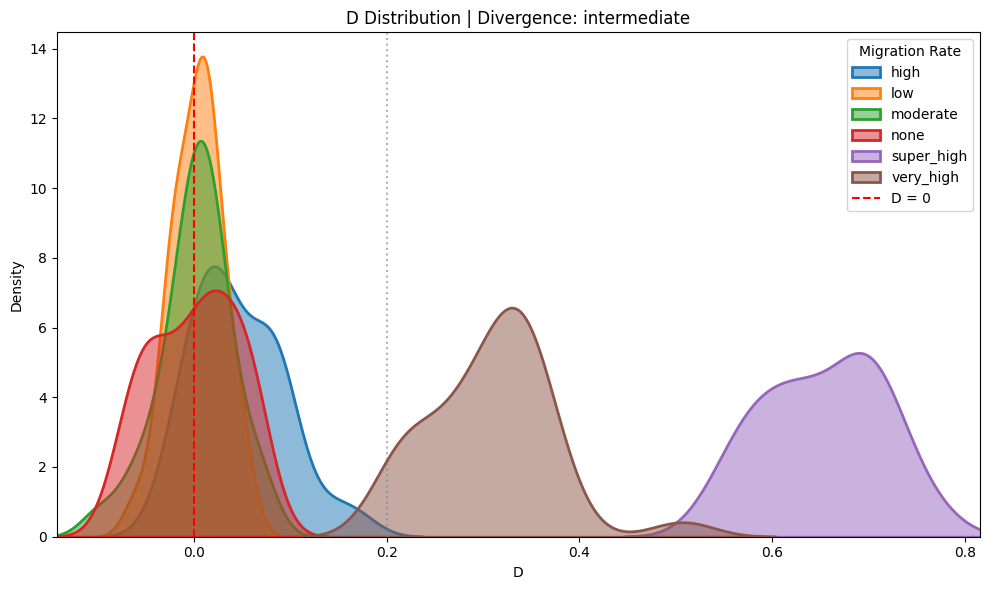

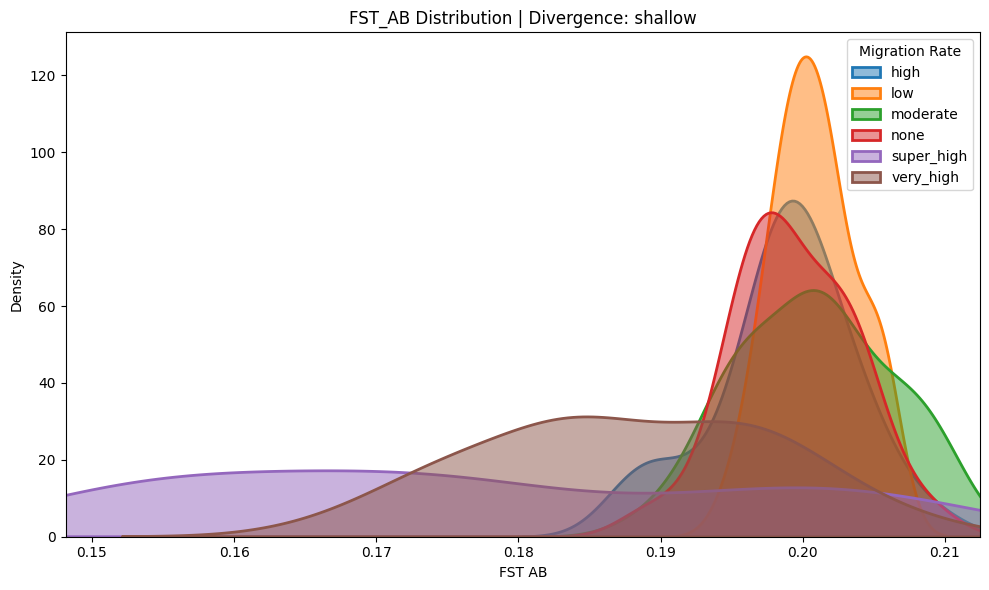

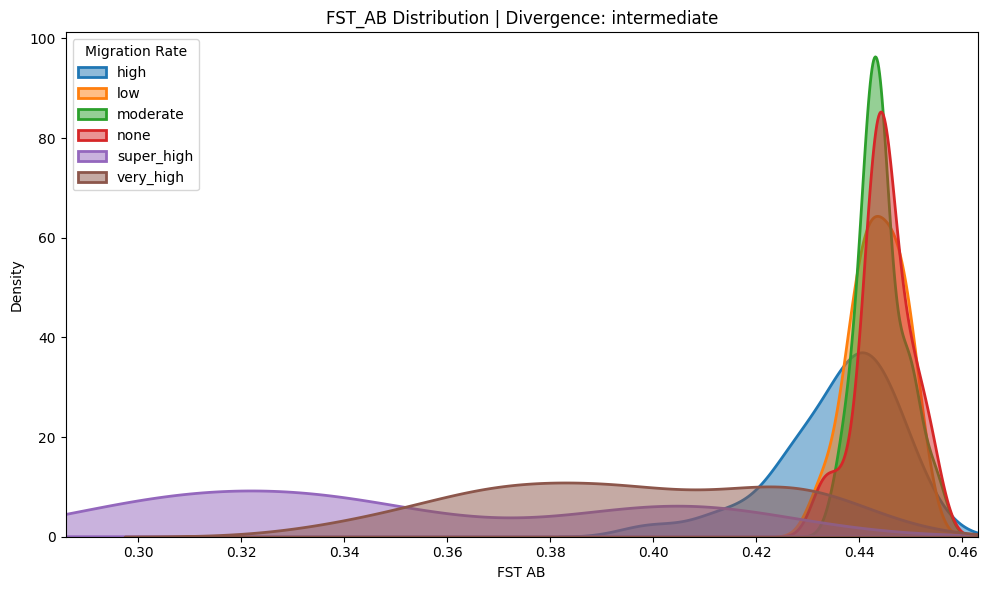

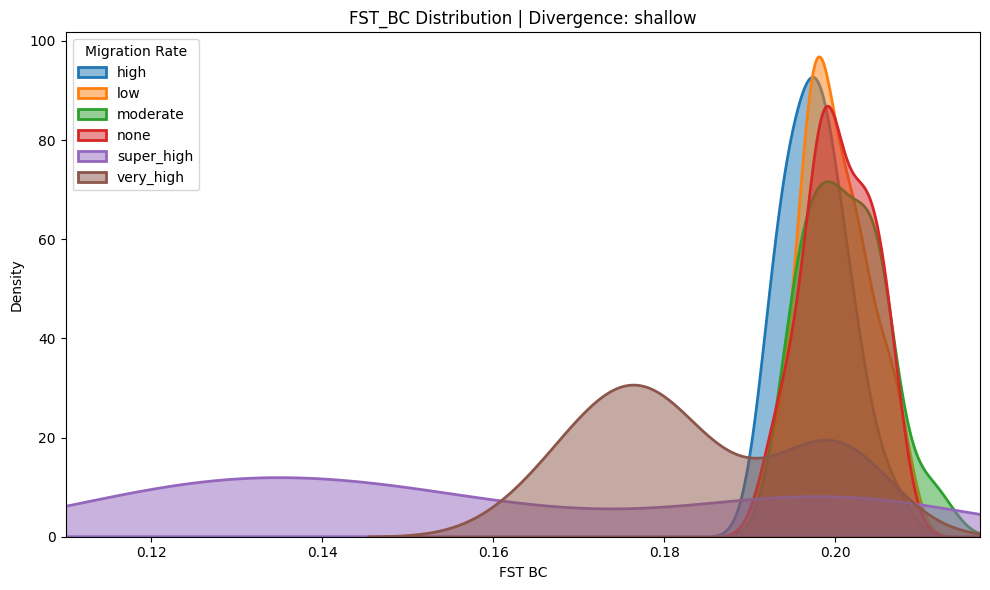

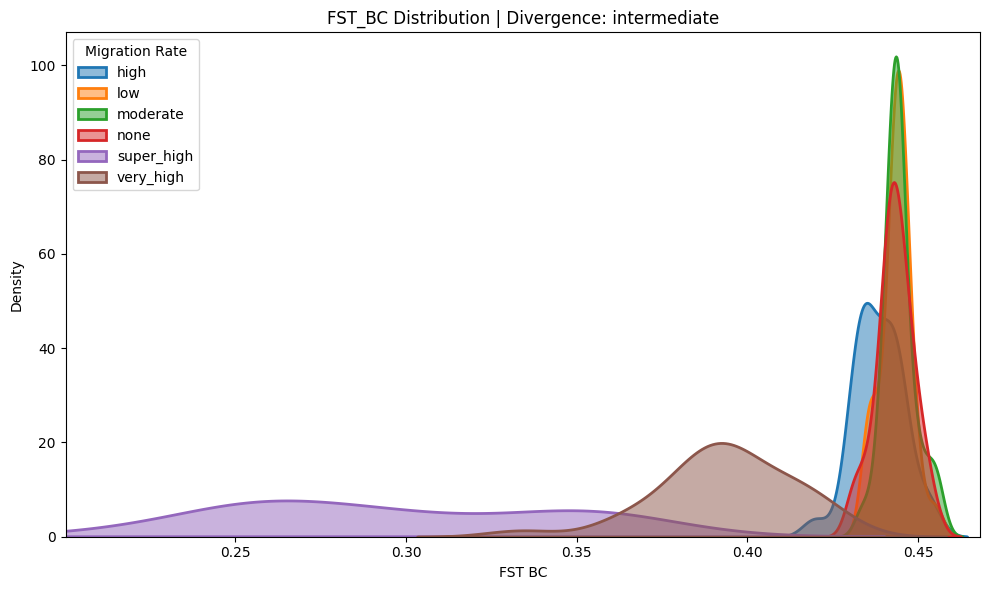

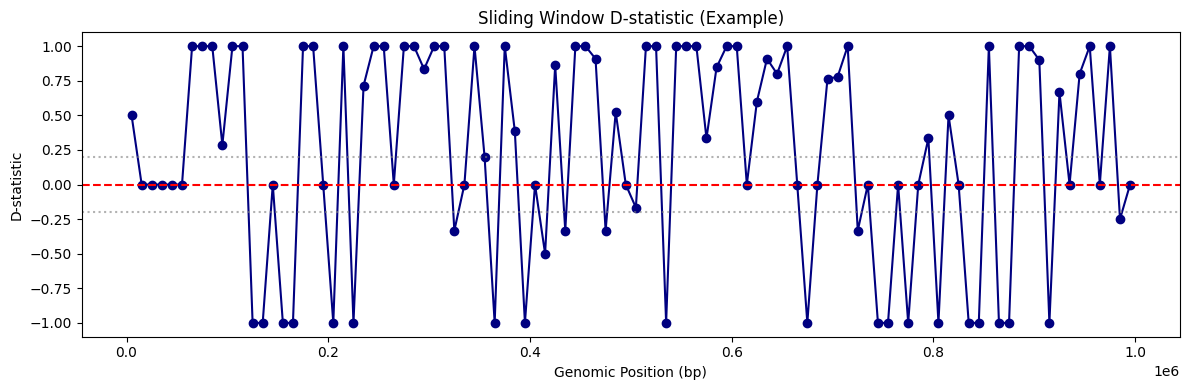

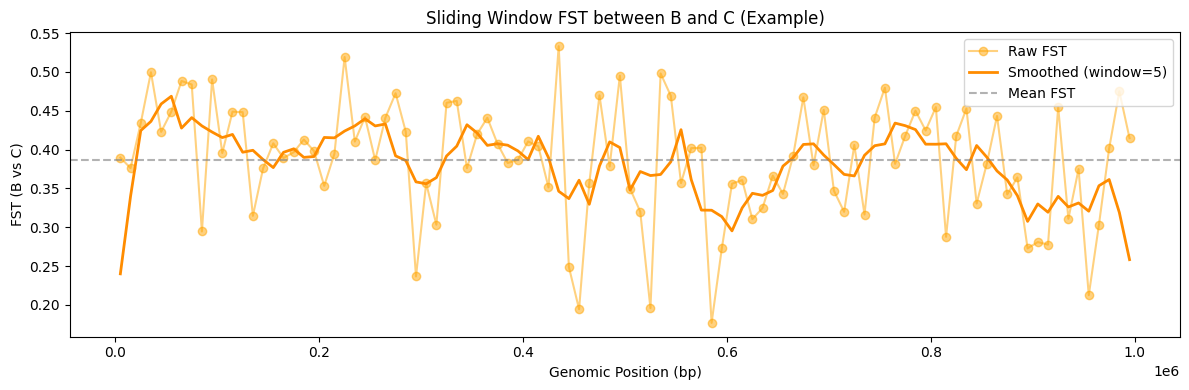

In [5]:
# 5.3.2 D-statistic Signatures Across Mixed Conditions and 5.3.3 FST Patterns and Heterogeneity

# === Load the results ===
df = pd.read_csv("results/mixed_updated/summary.csv")

# === Smarter KDE Plots: D-statistic + FST_AB + FST_BC ===
import seaborn as sns
import matplotlib.ticker as mtick

for metric in ["D", "FST_AB", "FST_BC"]:
    for div in df["divergence"].unique():
        subset = df[df["divergence"] == div]

        values = subset[metric].dropna()
        if values.empty:
            continue

        lower, upper = values.min(), values.max()
        margin = 0.05 * (upper - lower) if upper != lower else 0.1
        xlim_range = (lower - margin, upper + margin)

        # Clamp to [0, 1] if metric is FST
        if metric.startswith("FST"):
            xlim_range = (max(0, lower - margin), min(1, upper + margin))

        # KDE plot grouped by migration rate
        plt.figure(figsize=(10, 6))
        for mig_rate in sorted(subset["mig_rate"].unique()):
            group_data = subset[subset["mig_rate"] == mig_rate][metric]
            if not group_data.empty:
                sns.kdeplot(group_data, fill=True, label=mig_rate, linewidth=2, alpha=0.5)

        if metric == "D":
            plt.axvline(0, color="red", linestyle="--", label="D = 0")
            plt.axvline(0.2, color="gray", linestyle=":", alpha=0.6)
            plt.axvline(-0.2, color="gray", linestyle=":", alpha=0.6)

        plt.title(f"{metric} Distribution | Divergence: {div}")
        plt.xlabel(metric.replace("_", " "))
        plt.ylabel("Density")
        plt.xlim(xlim_range)
        plt.legend(title="Migration Rate")
        plt.tight_layout()
        plt.savefig(f"figures/mixed_updated/{metric}_{div}.png", dpi=300)
        plt.show()

# === Simulate one representative tree sequence for sliding window plots ===
ts_example = simulate_introgression_scenario(
    Ne=100000,
    div_time_ab=400000,
    div_time_abc=800000,
    mig_rate=0.1,
    mig_time=50000,
    continuous=False,
    migration_direction="C_to_B"
)

# --- D-statistic windows ---
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy')
plt.axhline(0, color='red', linestyle='--', label="D = 0")
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

d_margin = 0.05 * (max(d_stats) - min(d_stats)) if d_stats else 0.01
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic (Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_example.png", dpi=300)
plt.show()

# --- FST windows ---
fst_mids, fst_vals = sliding_window_fst(ts_example)

window = 5
smoothed = np.convolve(fst_vals, np.ones(window) / window, mode="same")

plt.figure(figsize=(12, 4))
plt.plot(fst_mids, fst_vals, marker='o', linestyle='-', color='orange', alpha=0.5, label="Raw FST")
plt.plot(fst_mids, smoothed, color='darkorange', linewidth=2, label=f"Smoothed (window={window})")
plt.axhline(np.mean(fst_vals), linestyle="--", color="gray", alpha=0.6, label="Mean FST")

fst_margin = 0.05 * (max(fst_vals) - min(fst_vals)) if fst_vals else 0.01
plt.ylim(min(fst_vals) - fst_margin, max(fst_vals) + fst_margin)

plt.title("Sliding Window FST between B and C (Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_fst_bc_example.png", dpi=300)
plt.show()


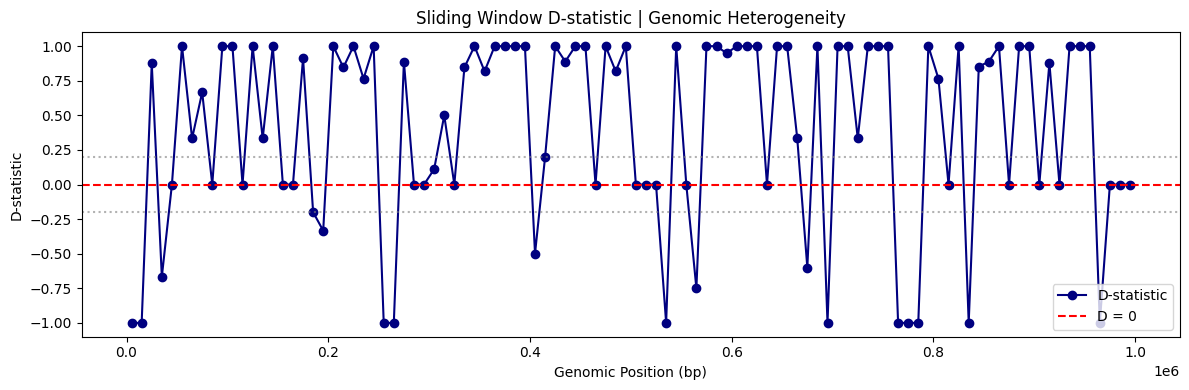

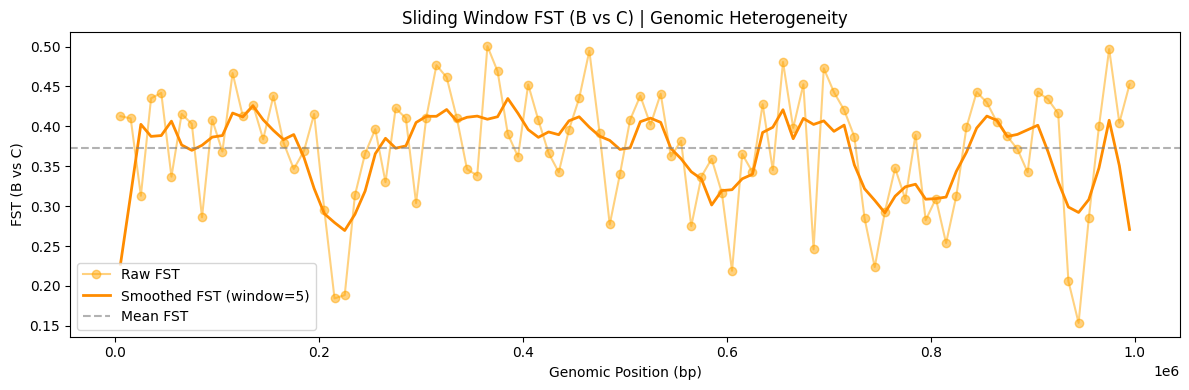

In [7]:
# === 5.3.5 Genomic Heterogeneity in Mixed Scenarios ===

ts_example = simulate_introgression_scenario(
    Ne=100000,
    div_time_ab=400000,
    div_time_abc=800000,
    mig_rate=0.1,               # high migration rate
    mig_time=50000,             # intermediate timing of introgression
    continuous=False,           # episodic introgression
    migration_direction="C_to_B"
)

# --- D-statistic: Sliding Window Plot ---
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy', label="D-statistic")
plt.axhline(0, color='red', linestyle='--', label="D = 0")
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

d_margin = 0.05 * (max(d_stats) - min(d_stats)) if d_stats else 0.01
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic | Genomic Heterogeneity")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_heterogeneity.png", dpi=300)
plt.show()

# --- FST (B vs C): Sliding Window Plot ---
fst_mids, fst_vals = sliding_window_fst(ts_example)

# Apply moving average smoothing
window = 5
smoothed = np.convolve(fst_vals, np.ones(window) / window, mode="same")

plt.figure(figsize=(12, 4))
plt.plot(fst_mids, fst_vals, marker='o', linestyle='-', alpha=0.5, color='orange', label="Raw FST")
plt.plot(fst_mids, smoothed, color='darkorange', linewidth=2, label=f"Smoothed FST (window={window})")
plt.axhline(np.mean(fst_vals), linestyle="--", color="gray", alpha=0.6, label="Mean FST")

fst_margin = 0.05 * (max(fst_vals) - min(fst_vals)) if fst_vals else 0.01
plt.ylim(min(fst_vals) - fst_margin, max(fst_vals) + fst_margin)

plt.title("Sliding Window FST (B vs C) | Genomic Heterogeneity")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_fst_heterogeneity.png", dpi=300)
plt.show()


In [7]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

# === Set up paths ===
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
simulations_path = os.path.join(project_root, 'simulations')
if simulations_path not in sys.path:
    sys.path.insert(0, simulations_path)

from common_utils import (
    simulate_introgression_scenario,
    calculate_d_statistic,
    calculate_fst,
    save_dataframe
)

# === Output folders ===
Path("results/expanded_grid").mkdir(parents=True, exist_ok=True)

# === Parameters ===
n_replicates = 10

Ne_values = [100000, 200000, 500000]  # small to large
divergence_scenarios = {
    "shallow": (100000, 200000),
    "intermediate": (400000, 800000),
    "ancient": (800000, 1600000)
}
migration_rates = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 0.1
}
migration_times = {
    "recent": 10000,
    "intermediate": 50000,
    "ancient": 200000
}
migration_models = ["episodic", "continuous"]
migration_directions = ["C_to_B", "symmetric"]  # symmetric is new

# === Run simulations ===
results = []

for Ne in Ne_values:
    for div_label, (div_time_ab, div_time_abc) in divergence_scenarios.items():
        for mig_time_label, mig_time in migration_times.items():
            for mig_label, mig_rate in migration_rates.items():
                for mig_model in migration_models:
                    for mig_direction in migration_directions:
                        for rep in tqdm(range(n_replicates),
                                        desc=f"{div_label}-{mig_time_label}-{mig_label}-{mig_model}-{mig_direction}-Ne{Ne}"):
                            continuous = True if mig_model == "continuous" else False

                            ts = simulate_introgression_scenario(
                                Ne=Ne,
                                div_time_ab=div_time_ab,
                                div_time_abc=div_time_abc,
                                mig_rate=mig_rate,
                                mig_time=mig_time,
                                continuous=continuous,
                                migration_direction=mig_direction
                            )

                            d_stat, abba, baba = calculate_d_statistic(ts)
                            fst_ab, fst_bc = calculate_fst(ts)

                            results.append({
                                "rep": rep,
                                "Ne": Ne,
                                "divergence": div_label,
                                "mig_time": mig_time_label,
                                "mig_rate": mig_label,
                                "mig_model": mig_model,
                                "mig_direction": mig_direction,
                                "D": d_stat,
                                "ABBA": abba,
                                "BABA": baba,
                                "FST_AB": fst_ab,
                                "FST_BC": fst_bc
                            })

# === Save dataframe ===
df = pd.DataFrame(results)
save_dataframe(df, "results/expanded_grid/summary.csv")


shallow-recent-none-continuous-C_to_B-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
shallow-recent-none-continuous-symmetric-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
shallow-recent-moderate-episodic-C_to_B-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
shallow-recent-moderate-episodic-symmetric-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]
shallow-recent-moderate-continuous-C_to_B-Ne100000: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]
shallow-recent-moderate-continuous-symmetric-Ne100000: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
shallow-recent-high-continuous-C_to_B-Ne100000: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
shallow-recent-high-continuous-symmetric-Ne100000: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]
shallow-recent-very_high-episodic-C_to_B-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]
shallow-recent-very_high-episodic-symmetric-Ne100000: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]
shallow

In [10]:
import pandas as pd

# Load the expanded simulation results
df = pd.read_csv("results/expanded_grid/summary.csv")

# Select key columns to summarize by
group_cols = ["divergence", "Ne", "mig_model", "mig_direction", "mig_rate", "mig_time"]

# Compute the summary statistics
summary_stats = (
    df
    .groupby(group_cols)
    .agg(
        mean_D=("D", "mean"),
        std_D=("D", "std"),
        mean_FST_BC=("FST_BC", "mean"),
        std_FST_BC=("FST_BC", "std")
    )
    .reset_index()
)

print(summary_stats.head())

  divergence      Ne   mig_model mig_direction mig_rate      mig_time  \
0    ancient  100000  continuous        C_to_B     high       ancient   
1    ancient  100000  continuous        C_to_B     high  intermediate   
2    ancient  100000  continuous        C_to_B     high        recent   
3    ancient  100000  continuous        C_to_B      low       ancient   
4    ancient  100000  continuous        C_to_B      low  intermediate   

     mean_D     std_D  mean_FST_BC  std_FST_BC  
0  1.001693  0.002792     0.025671    0.001268  
1  1.001159  0.002707     0.026453    0.001546  
2  1.000400  0.001837     0.027121    0.001892  
3  0.861241  0.020296     0.392648    0.017237  
4  0.887113  0.014650     0.375656    0.017809  


# Sliding Window Plots



In [4]:
import sys
sys.path.append("/Users/rachaelchew/Evolutionary-Genetics-Research/simulations")

from common_utils import sliding_window_d

ts_example = simulate_introgression_scenario(
    Ne=100000,
    div_time_ab=400000,
    div_time_abc=800000,
    mig_rate=0.1,
    mig_time=50000,
    continuous=False,
    migration_direction="C_to_B"
)


# === Sliding Window D-statistic ===
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy', label="D-statistic")
plt.axhline(0, color='red', linestyle='--', label="D = 0")
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

d_margin = 0.05 * (max(d_stats) - min(d_stats)) if d_stats else 0.01
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic | Genomic Heterogeneity")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_heterogeneity.png", dpi=300)
plt.show()


NameError: name 'simulate_introgression_scenario' is not defined